In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import btb.utils.tools as btbtools
import btb.utils.wikiquery as wq

import mwclient
import pickle
from collections import defaultdict

In [3]:
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

In [4]:
from IPython.display import Image

In [5]:
wikiEN = mwclient.Site('en.wikipedia.org')
# wikiEN = btbtools.getDebugWiki()
bots = wq.getAllBots(wikiEN)
expEdPct = wq.getTotalContributions() # Expected percentage of edits per country

In [6]:
def randomTitles(wikiEN, nTitles):
    '''
    Generator of random Wikipedia pages.
    '''
    for i in range(int(nTitles/10)):
        randPages = wikiEN.random(namespace=0, limit=10)
        for page in randPages:
            yield page['title']

In [7]:
def categoryTitles(wikiEN, catName, nTitles):
    '''
    Generator of random Wikipedia pages in a category.
    
    NOTE: ordering of items in the category is always the same.
    
    eg: categoryTitles(wikiEN, 'Cities in the Netherlands', 20)
    '''
    wikiCat = wikiEN.categories[catName]
    for i in range(nTitles):
        catPage = wikiCat.next()
        yield catPage.name

In [110]:
def unpackContributions(cmpEdits):
    ''' previously dict comprehension: 
    { ctry: ac for ctry,(ex,ac,cm) in cmpEdits.iteritems() } 
    
    except added an if  to avoid empty keys which cause problems 
    when pickling '''
    edits = {}
    for ctry,(ex,ac,cm) in cmpEdits.iteritems():
        if ctry=='':
            ctry = '_'
        edits[ctry] = ac
    return edits

def fetchContributions(titles):
    '''
    Parameters:
        titles    Generator of titles to be fetched
    Return:
        dictionary of title: contribution percentages
    '''
    # TODO: Maybe make into a generator ?
    cumEdCount = []
    for pageTitle in titles:
        ips, usrs, nrevs = wq.getContributionsForPage(wikiEN, pageTitle)
        revCount, conf, nIP, nUsr, nBot, nUnkn = btbtools.prepareData(ips, usrs, bots)

        # Blank keys cause pickling problems
        if '' in revCount.keys():
            del revCount['']
        
        cumEdCount.append((pageTitle, revCount))
    return cumEdCount

In [68]:
def getContributionSummary(pageContribs):
    # Normalization factor:
    # Weight each contribution by a normalization factor dependent on the 
    # total weight of all contributions
    normFactor = sum( sum(contribs.values()) for _,contribs in pageContribs )
    
    edPct = defaultdict(float)
    for title,pageEdPct in pageContribs:
        for ctry,pct in pageEdPct.iteritems():
            edPct[ctry] += pct / normFactor
    #edPct = dict(edPct)
    return edPct



In [42]:
def getEditError(globalContribsPct):
    assert sum(globalContribsPct.values())<1.1, 'Global contributions should add up to 1' # Plus 10% margin
    editDiff = []
    for e in expEdPct:
        ex = expEdPct[e]
        ac = globalContribsPct[e] if e in globalContribsPct else 0
        editDiff.append(ac-ex)
    editDiff = np.array(editDiff)
    return (editDiff**2).sum()

In [60]:
def plotContribError(pageContribs):
    err = []
    cumContribsCount = defaultdict(float)
    
    for pageTitle, pageContribCount in pageContribs:
        for ctry,edCount in pageContribCount.iteritems():
            cumContribsCount[ctry] += edCount
        cmpEdits = btbtools.compareEdits(expEdPct, cumContribsCount)
        cumContribsPct = unpackContributions(cmpEdits)
        err.append(getEditError(cumContribsPct))

    semilogy(err)
    axis([ 0, len(pageContribs), 0, 1]);


In [22]:
def plotHistogramContributions(pageContribs, fig=None):
    if fig==None:
        figure(figsize=(12,4))

    actEdPct = getContributionSummary(pageContribs)

    tags   = np.array(expEdPct.keys())
    cmpVals = np.array(expEdPct.values())

    # Sort descending by expected value
    sortIdx = cmpVals.argsort()
    sortIdx = sortIdx[::-1]
    tags   = tags[sortIdx]

    expVal = [ expEdPct[ctry] for ctry in tags ]
    actVal = [ actEdPct[ctry] for ctry in tags ]

    # Format bar charts
    width = 0.35
    N = len(tags)
    ind = np.arange(N)

    bar(ind           , expVal, width=width, color='y', label='Expectation')
    bar(ind + width   , actVal, width=width, color='r', label='Contribution')
    xticks(ind + width, tags  , rotation=90)

# Fetch data from Wikipedia

In [81]:
import datetime
def printTimestampMessage(msg=''):
    currTime = datetime.datetime.now()
    print currTime.strftime('[%H:%M:%S]'),msg


In [71]:
titles = randomTitles(wikiEN, 500)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribsRandom.pkl', 'w'))

In [ ]:
printTimestampMessage('Start')
titles = categoryTitles(wikiEN, 'Cities in the Netherlands', 500)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribs_citiesNL.pkl', 'w'))
printTimestampMessage('Finish')

In [ ]:
titles = randomTitles(wikiEN, 1000)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribsRandom1000A.pkl', 'w'))

In [ ]:
titles = randomTitles(wikiEN, 1000)
pageContribs = fetchContributions(titles)
pickle.dump(pageContribs, open('PageContribsRandom1000B.pkl', 'w'))

# Plot data

In [123]:
def makeFrame(i, pageContribs):
    gcf().clear()
    plotHistogramContributions(pageContribs[:i], gcf())
    title('Title %d'%i)
    img = mplfig_to_npimage(gcf())
    return img

def wrapMakeFrame(f, pageContribs, fps):
    i = int(f * fps)+1
    #print 'F: ', f, ' -> ', i
    return makeFrame(i, pageContribs)

def buildAnimation(pageContribs, aniFile, duration):
    fps = len(pageContribs) / duration
    trueFps = fps if fps<24 else 24
    #print 'We have to display %f frames each second, so in %d seconds, we display %d frames'%(fps, duration, len(pageContribs))
    
    fig = figure(figsize=(12,4))
    lambdaMakeFrame = lambda f: wrapMakeFrame(f, pageContribs, fps)

    animation =mpy.VideoClip(lambdaMakeFrame, duration=duration)
    animation.write_gif(aniFile, fps=trueFps)
    close()

## 500 random Wikipedia pages

In [111]:
pageContribs = pickle.load(open('PageContribsRandom.pkl', 'r'))

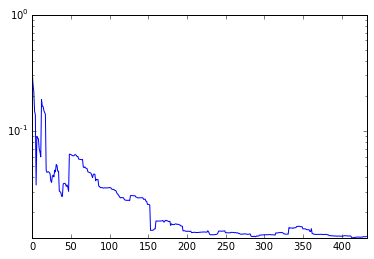

In [112]:
plotContribError(pageContribs)

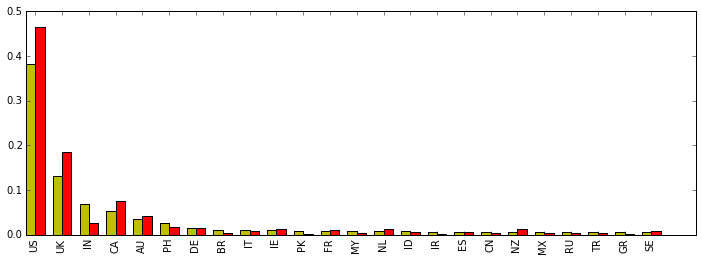

In [113]:
plotHistogramContributions(pageContribs)

In [114]:
buildAnimation(pageContribs, 'random.gif', duration=20)

We have to display 8.660000 frames each second, so in 50 seconds, we display 433 frames

[MoviePy] Building file random.gif with imageio


In [116]:
Image(url='random.gif')

## Category: cities in the netherlands

In [118]:
pageContribs = pickle.load(open('PageContribs_citiesNL.pkl', 'r'))

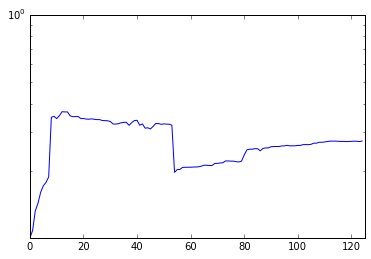

In [119]:
plotContribError(pageContribs)

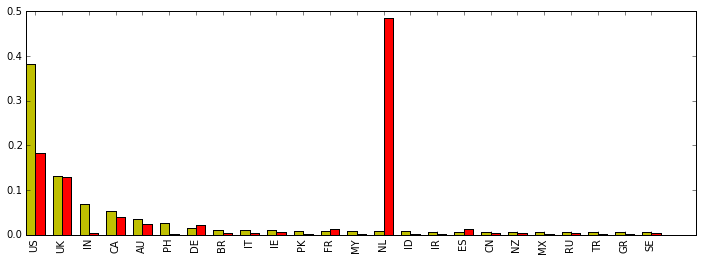

In [122]:
plotHistogramContributions(pageContribs)

In [120]:
buildAnimation(pageContribs, 'cities_nl.gif', duration=20)

We have to display 6.250000 frames each second, so in 20 seconds, we display 125 frames

[MoviePy] Building file cities_nl.gif with imageio


In [121]:
Image(url='cities_nl.gif')

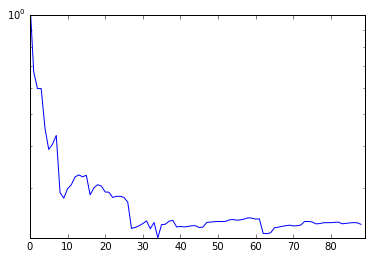

In [179]:
pageContribs = pickle.load(open('PageContribs_Tram_transport_in_Germany.pkl', 'r'))
plotContribError(pageContribs)

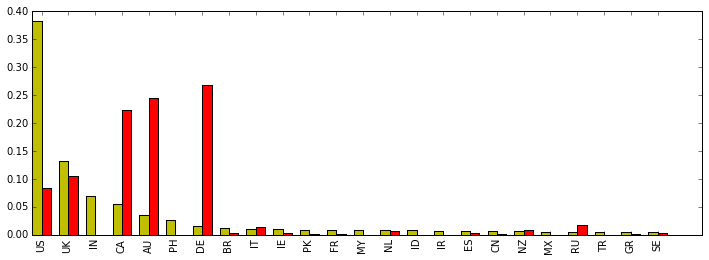

In [180]:
plotHistogramContributions(pageContribs)

In [181]:
buildAnimation(pageContribs, 'PageContribs_Tram_transport_in_Germany.gif', duration=20)
Image(url='PageContribs_Tram_transport_in_Germany.gif')


[MoviePy] Building file PageContribs_Tram_transport_in_Germany.gif with imageio


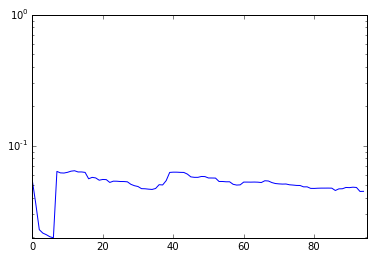

In [182]:
pageContribs = pickle.load(open('PageContribs_Crops originating from the Americas.pkl', 'r'))
plotContribError(pageContribs)

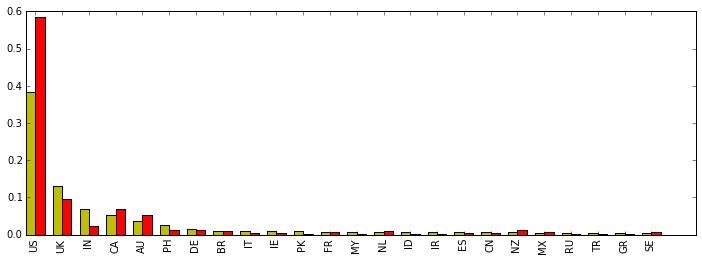

In [183]:
plotHistogramContributions(pageContribs)

In [184]:
buildAnimation(pageContribs, 'PageContribs_Crops originating from the Americas.gif', duration=20)
Image(url='PageContribs_Crops originating from the Americas.gif')


[MoviePy] Building file PageContribs_Crops originating from the Americas.gif with imageio


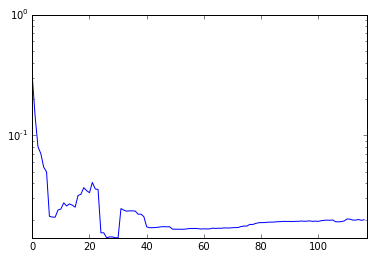

In [185]:
pageContribs = pickle.load(open('PageContribs_German heavy metal musical groups.pkl', 'r'))
plotContribError(pageContribs)

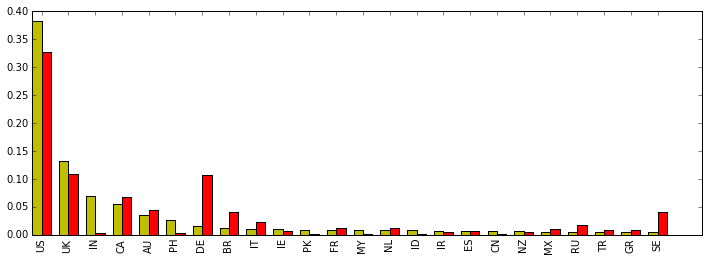

In [186]:
plotHistogramContributions(pageContribs)

In [187]:
buildAnimation(pageContribs, 'PageContribs_German heavy metal musical groups.gif', duration=20)
Image(url='PageContribs_German heavy metal musical groups.gif')


[MoviePy] Building file PageContribs_German heavy metal musical groups.gif with imageio


In [ ]:
pageContribs = pickle.load(open('x.pkl', 'r'))
plotContribError(pageContribs)

In [ ]:
plotHistogramContributions(pageContribs)

In [ ]:
buildAnimation(pageContribs, 'x.gif', duration=20)
Image(url='x.gif')

In [124]:
pageContribs = pickle.load(open('PageContribsRandom1000A.pkl', 'r'))

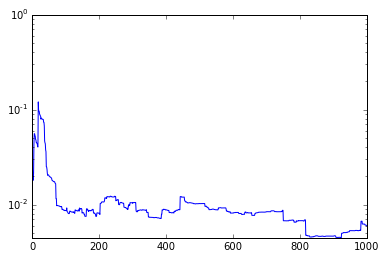

In [125]:
plotContribError(pageContribs)

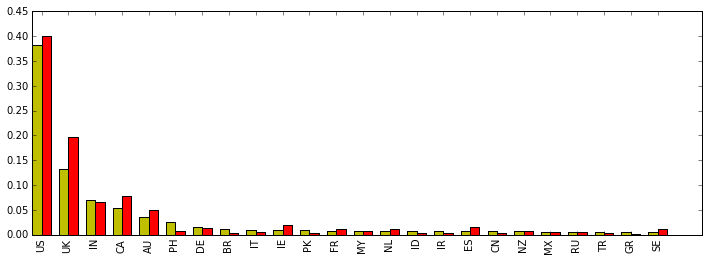

In [126]:
plotHistogramContributions(pageContribs)

In [127]:
buildAnimation(pageContribs, 'PageContribsRandom1000A.gif', duration=20)
Image(url='PageContribsRandom1000A.gif')


[MoviePy] Building file PageContribsRandom1000A.gif with imageio


In [169]:
from glob import glob

In [188]:
pageContribs = []
allTitles = set()

for filename in glob('PageContribsRandom1000*.pkl'):
    pklData = pickle.load(open(filename, 'r'))
    for pageTitle,dist in pklData:
        if pageTitle in allTitles:
            print 'Repeated: ',pageTitle
        else:
            allTitles.add(pageTitle)
            pageContribs.append((pageTitle,dist))
    

Repeated:  Kallam Anji Reddy
Repeated:  Sagentia
Repeated:  Penzing, Bavaria
Repeated:  R. C. Robertson-Glasgow
Repeated:  AN/SPS-43
Repeated:  Karakobis
Repeated:  Ghost Stories Tour
Repeated:  Jack Cattell
Repeated:  St Michaels & Wicksteed (Kettering BC Ward)
Repeated:  Bridgend Designer Outlet


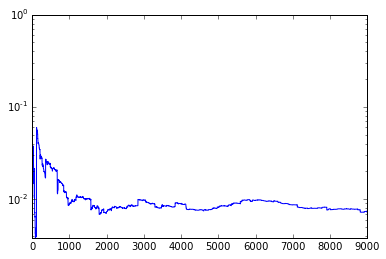

In [171]:
plotContribError(pageContribs)

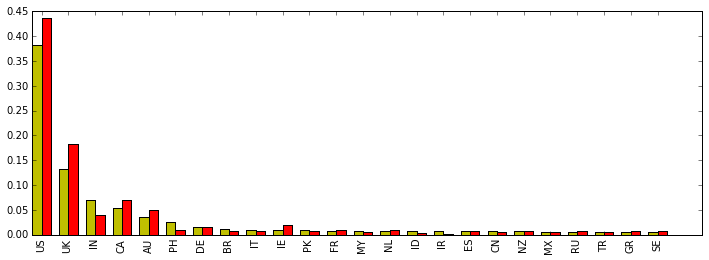

In [172]:
plotHistogramContributions(pageContribs)

In [173]:
buildAnimation(pageContribs, 'PageContribsRandom-all.gif', duration=20)
Image(url='PageContribsRandom-all.gif')


[MoviePy] Building file PageContribsRandom-all.gif with imageio


0.377975528365
14.31783402


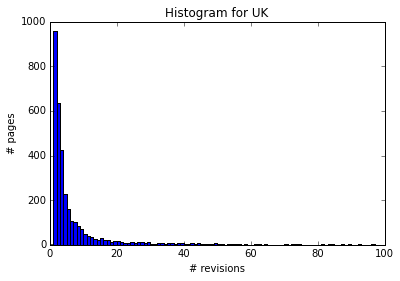

In [209]:
allBritish = []
n = 0
britishRevs = []
for pageTitle, contribs in pageContribs:
    cmpEdits = btbtools.compareEdits(expEdPct, contribs)
    contribsPct = unpackContributions(cmpEdits)
    if 'UK' in contribsPct and contribsPct['UK']>0.15:
        n += 1
        allBritish.append(pageTitle)
        britishRevs.append(contribs['UK'])
print n/len(pageContribs)
print np.mean(britishRevs)

hist(britishRevs, bins=arange(0,100,1))
xlabel('# revisions')
ylabel('# pages')
title('Histogram for UK')

0.353281423804
40.0324307305


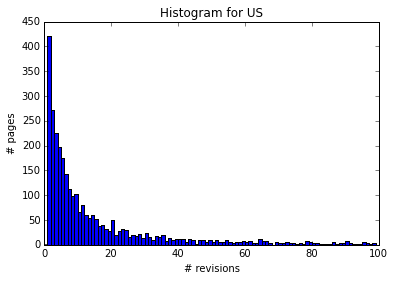

In [210]:
allBritish = []
n = 0
britishRevs = []
for pageTitle, contribs in pageContribs:
    cmpEdits = btbtools.compareEdits(expEdPct, contribs)
    contribsPct = unpackContributions(cmpEdits)
    if 'US' in contribsPct and contribsPct['US']>0.40:
        n += 1
        allBritish.append(pageTitle)
        britishRevs.append(contribs['US'])
print n/len(pageContribs)
print np.mean(britishRevs)

hist(britishRevs, bins=arange(0,100,1))
xlabel('# revisions')
ylabel('# pages')
title('Histogram for US')

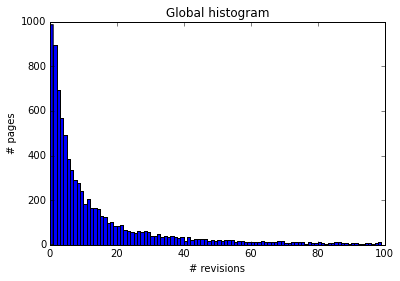

In [211]:
totalRevs = []
for pageTitle, contribs in pageContribs:
    totalRevs.append(sum(contribs.values()))
hist(totalRevs, bins=arange(0,100,1));
np.mean(totalRevs)

xlabel('# revisions')
ylabel('# pages')
title('Global histogram')